# 🎯 Projeto – Bagging Regressão

Uma [**HealthTech**](#) realizou uma pesquisa com mais de **1.300 pessoas** sobre gastos realizados com saúde nos últimos **2 anos** para criar uma oferta mais assertiva de planos de saúde para pequenas e médias empresas.

🧩 Dentre os componentes para formatar esta oferta, é importante:
- Conseguir estimar os gastos de saúde dos funcionários de uma possível empresa cliente
- Basear-se em algumas características destes funcionários

---

## 🔍 Objetivo

Para apoiar o desenvolvimento desta oferta, iremos trabalhar em **um algoritmo de regressão** que possa:

- 📈 Estimar os gastos de saúde de funcionários

Considerando:
- O volume de dados
- As features disponíveis

Adotaremos:
- 🛠️ O método Bagging de ensemble, usando **algoritmos supervisionados de regressão**

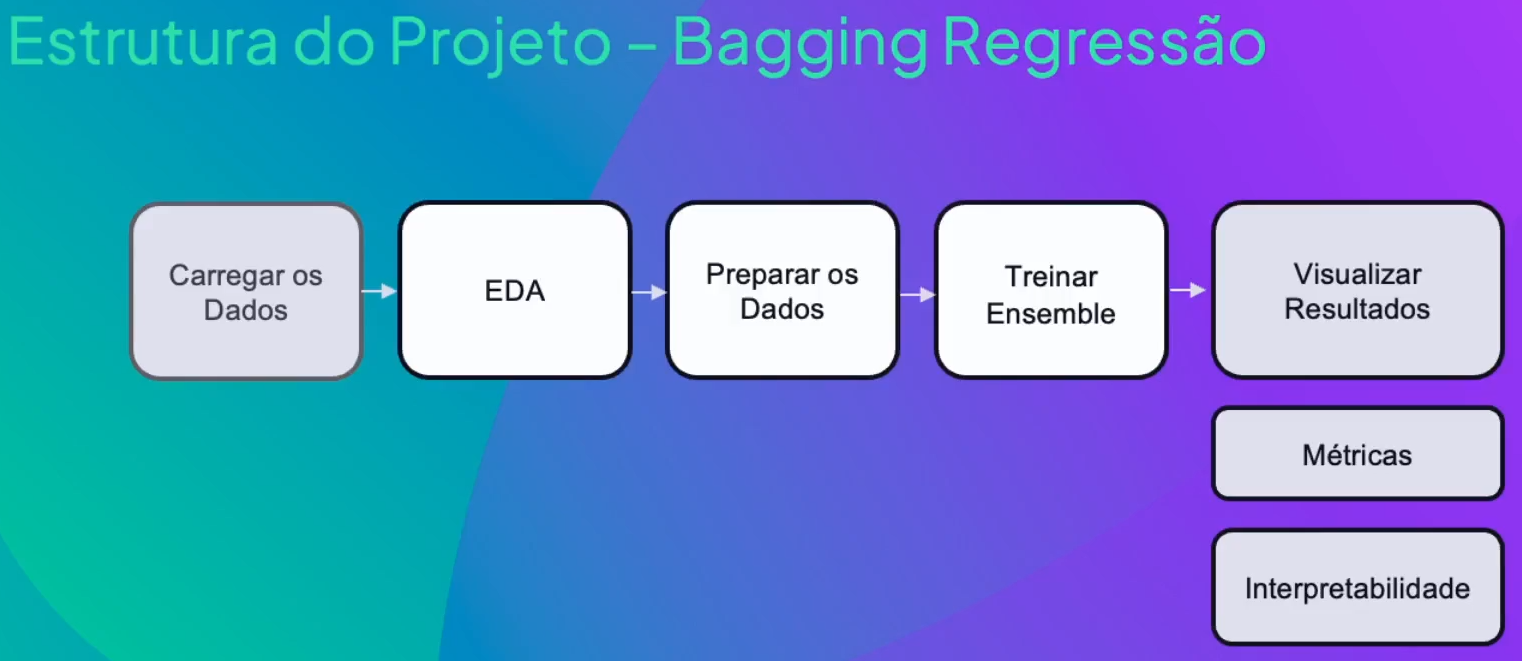

In [1]:
# Importar bibliotecas

import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

### Carregar Dados

In [2]:
# Carregar os dados
df_costs = pd.read_csv('./datasets/healthcosts.csv')

In [3]:
# Mostrar as primeiras linhas do dataframe
df_costs.head(10)

,age,sex,bmi,children,smoker,region,medical charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [4]:
# Mostrar as ultimas linhas do dataframe
df_costs.tail(10)

,age,sex,bmi,children,smoker,region,medical charges
1328,23,female,24.225,2,no,northeast,22395.74424
1329,52,male,38.600,2,no,southwest,10325.20600
1330,57,female,25.740,2,no,southeast,12629.16560
1331,23,female,33.400,0,no,southwest,10795.93733
1332,52,female,44.700,3,no,southwest,11411.68500
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500
1337,61,female,29.070,0,yes,northwest,29141.36030


In [14]:
# Mostrar estrutura do dataframe
df_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              1338 non-null   int64  
 1   sex              1338 non-null   object 
 2   bmi              1338 non-null   float64
 3   children         1338 non-null   int64  
 4   smoker           1338 non-null   int64  
 5   region           1338 non-null   object 
 6   medical charges  1338 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 73.3+ KB


### Feature Engineering

In [7]:
# Mostrar e remover as colunas categoricas que possuem somente um valor possivel
for column in df_costs.select_dtypes(include=['object']).columns:
    if df_costs[column].nunique() == 1:
        print(f'Coluna {column} possui somente um valor possível: {df_costs[column].unique()}')

In [8]:
# Mostrar os valores possiveis para todas as colunas categoricas
for column in df_costs.select_dtypes(include=['object']).columns:
    print(f'Coluna {column} possui estes valores: {df_costs[column].unique()}')

Coluna sex possui estes valores: ['female' 'male']
Coluna smoker possui estes valores: ['yes' 'no']
Coluna region possui estes valores: ['southwest' 'southeast' 'northwest' 'northeast']


In [9]:
# Mostrar o percentual de valores ausentes para as colunas categoricas
for column in df_costs.select_dtypes(include=['object']).columns:
    contagem_nulas = df_costs[column].isnull().sum()
    print(f'{column}: {contagem_nulas / len(df_costs) * 100:.2f}%')

sex: 0.00%
smoker: 0.00%
region: 0.00%


In [10]:
# Apresentar Estatisticas Descritivas
df_costs.describe()

,age,bmi,children,medical charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [11]:
# Mostrar e remover as colunas numericas que possuem somente um valor possivel
for column in df_costs.select_dtypes(include=['number']).columns:
    if df_costs[column].nunique() == 1:
        print(f'Coluna {column} possui somente um valor possível: {df_costs[column].unique()}')

In [12]:
# Mostrar o percentual de valores ausentes para as colunas numericas
for column in df_costs.select_dtypes(include=['number']).columns:
    contagem_nulas = df_costs[column].isnull().sum()
    print(f'{column}: {contagem_nulas / len(df_costs) * 100:.2f}%')

age: 0.00%
bmi: 0.00%
children: 0.00%
medical charges: 0.00%


In [13]:
# Converter colunas categoricas com valores Yes e No para 1 e 0
for column in df_costs.select_dtypes(include=['object']).columns:
    valores_unicos = df_costs[column].unique()
    if set(valores_unicos).issubset(set(['yes', 'no'])):
        df_costs[column] = df_costs[column].apply(lambda x: 1 if x == 'yes' else 0)

### EDA

In [15]:
# Mostrar distribuicao de custos medicos
fig = px.histogram(df_costs, x='medical charges', nbins=30, title='Distribuição de Custos Médicos')
fig.show()

In [16]:
# Mostrar distribuicao de idade
fig = px.histogram(df_costs, x='age', nbins=30, title='Distribuição da Idade')
fig.show()

In [17]:
# Mostrar a quantidade de filhos
fig = px.histogram(df_costs, x='children', title='Distribuição de Quantidade de Filhos')
fig.show()

In [18]:
# Mostrar distribuicao de BMI
fig = px.histogram(df_costs, x='bmi', nbins=30, title='Distribuição de BMI')
fig.show()

In [20]:
# Mostrar a distribuicao do genero
fig = px.bar(df_costs['sex'].value_counts(), title='Distribuição por Gênero')
fig.show()

In [22]:
# Mostrar a distribuicao da variavel Smoker
fig = px.bar(df_costs['smoker'].value_counts(), title='Distribuição de Fumante')
fig.show()

In [23]:
# Mostrar a distribuicao por regiao
fig = px.bar(df_costs['region'].value_counts(), title='Distribuição por Região')
fig.show()

In [24]:
# Boxplot de custos medicos por idade
fig = px.box(df_costs, x='age', y='medical charges', title='Boxplot de Custos Médicos por Idade')
fig.show()

In [26]:
# Boxplot de custos medicos por genero
fig = px.box(df_costs, x='sex', y='medical charges', title='Boxplot de Custos Médicos por Gênero')
fig.show()

In [27]:
# Boxplot de custos medicos por Smoker
fig = px.box(df_costs, x='smoker', y='medical charges', title='Boxplot de Custos Médicos por Status de Fumante')
fig.show()

In [28]:
# Boxplot de custos medicos por regiao
fig = px.box(df_costs, x='region', y='medical charges', title='Boxplot de Custos Médicos por Região')
fig.show()

In [29]:
# Plot de correlacao das variaveis numericas
corr_matrix = df_costs.select_dtypes(include=['number']).corr()

In [30]:
# Mostrar a matriz de correlacao
corr_matrix

,age,bmi,children,smoker,medical charges
age,1.000000,0.109272,0.042469,-0.025019,0.299008
bmi,0.109272,1.000000,0.012759,0.003750,0.198341
children,0.042469,0.012759,1.000000,0.007673,0.067998
smoker,-0.025019,0.003750,0.007673,1.000000,0.787251
medical charges,0.299008,0.198341,0.067998,0.787251,1.000000


In [33]:
fig = go.Figure()

fig.add_trace(
    go.Heatmap(
        x=corr_matrix.columns,
        y=corr_matrix.index,
        z=np.array(corr_matrix),
        text=corr_matrix.values,
        texttemplate='%{text:.3f}',
        colorscale=px.colors.diverging.RdBu,
        zmin=-1,
        zmax=1
    )
)

fig.show()

### Preparação dos Dados

In [34]:
# Preparar dados para o modelo
X = df_costs.drop(columns=['medical charges'])
y= df_costs['medical charges']

In [35]:
# Column Transformer para normalizar variaveis numericas e OneHotEncode para categoricas
numeric_features = X.select_dtypes(include=['number']).columns
categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [36]:
# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=51)

In [37]:
# Aplicar Column Transformer nos dados de treinamento e teste
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [38]:
# Mostrar as dimensoes dos conjuntos
print(f'Dados de treinamento: {X_train.shape}')
print(f'Dados de teste: {X_test.shape}')

Dados de treinamento: (1070, 10)
Dados de teste: (268, 10)


### Treinamento do modelo

In [ ]:
# Criar o modelo de Baggins Regressor
bagging_model = BaggingRegressor(
    estimator=LinearRegression(),
    n_estimators=10,
    random_state=51
    #max_samples=0.5
    #max_features=0.4
)

In [111]:
# Treinar o modelo
bagging_model.fit(X_train, y_train)

BaggingRegressor(estimator=LinearRegression(), random_state=51)

### Análise dos Resultados

In [112]:
# Fazer predicoes com base no modelo treinado
y_pred = bagging_model.predict(X_test)

In [113]:
# Mostrar y_pred
y_pred

array([ 8867.59078872, 36805.27813018,  2786.29194648, 11178.02788322,
       34023.55812248, 11612.68697707, 11555.24008631, 14975.75609284,
        5348.73841345, 10644.35007315,  9542.26478237, 12182.41562307,
        9963.18077502,  4197.02159732,  5495.5510617 , 12669.2259207 ,
        5654.27949942,  4898.19412627, 25738.02597205, 28755.29531981,
       10316.69436656,  8508.57070827, 32483.07329171, 13179.23439342,
        6165.46369588, 16089.92921178,  9917.10593579,  2575.88579687,
       23361.22140021,  8252.34064   ,  3894.4856253 , 30294.22573616,
        5737.14627997,  4710.06736037,  7789.91871347, 11150.60813685,
       13288.03609118,  2140.55532123, 12153.81159574,  7783.63881065,
        9844.16523243,   822.46724682,  5950.84135369,  2147.76049849,
        4277.11067328, 15121.58202627, 15339.42995097, 35018.97097488,
        8205.65604559, 12731.46150312,  5643.31124535, 30716.57617381,
        6984.39166773, 39973.66994033,  4436.59198834, 27572.45121014,
      

In [114]:
# Avaliar metricas do modelo
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [115]:
# Mostrar o Erro e R2 do Modelo
print(f'Root Mean Squared Error: {rmse}')
print(f'R2: {r2}')

Root Mean Squared Error: 6613.208775044856
R2: 0.7484823756086139


In [116]:
# Calcular a importancia das features usando os coeficientes

# Obter os coeficientes de cada estimados
coefs = np.array([estimator.coef_ for estimator in bagging_model.estimators_])

# Calcular a media dos coeficientes absolutos
feature_importance = np.mean(np.abs(coefs), axis=0)

# Normalizar as importancias
feature_importance = feature_importance / np.sum(feature_importance)

In [117]:
# Obter os nomes da features
feature_names = preprocessor.get_feature_names_out()

In [118]:
# Criar um dataframe com as importancias e os nomes
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})

# Ordenar o dataframe pela importancia
importance_df = importance_df.sort_values('importance', ascending=True)

In [119]:
# Criar o grafico de barras para mostrar a importancia das features
fig = px.bar(importance_df, x='importance', y='feature', title='Importância das Features',
             orientation='h')
fig.update_xaxes(tickangle=45)
fig.show()

### Verificar propriedades do modelo

In [120]:
bagging_model.estimators_samples_

[array([503, 347, 592, ..., 894, 379, 343], dtype=int32),
 array([914,  70, 844, ..., 436, 320, 822], dtype=int32),
 array([151, 735, 546, ..., 669, 536, 198], dtype=int32),
 array([405, 317,  32, ..., 592, 790, 440], dtype=int32),
 array([776, 345, 478, ..., 102, 934, 750], dtype=int32),
 array([ 514, 1037,  824, ...,  827,  842,  876], dtype=int32),
 array([ 350,  900, 1045, ...,  167,  341,  985], dtype=int32),
 array([649, 979, 314, ..., 376, 597, 985], dtype=int32),
 array([875, 670, 998, ..., 114, 230, 555], dtype=int32),
 array([ 962, 1069,  677, ..., 1051,  745,  898], dtype=int32)]

In [121]:
bagging_model.estimators_samples_[3].shape

(1070,)

In [122]:
bagging_model.estimators_features_

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]

### Salvar dados e pre-processador do modelo

In [123]:
# Salvar dataframe como CSV
df_costs.to_csv('./datasets/healthcosts_cleaned.csv', index=False)

In [124]:
# Salvar o preprocessor
import joblib

joblib.dump(preprocessor, './preprocessor_dataset_healthcosts.pkl')

['./preprocessor_dataset_healthcosts.pkl']